複数のAdapterで最適化問題を解いて結果を比較する
=========================================

OMMX Adapterは共通化されたAPIを持っているので、複数のソルバーを使って同じ問題を解いて結果を比較することができます。まず例として簡単なナップザック問題を考えましょう：

$$
\begin{align*}
\mathrm{maximize} \quad & \sum_{i=0}^{N-1} v_i x_i \\
\mathrm{s.t.} \quad & \sum_{i=0}^{n-1} w_i x_i - W \leq 0, \\
& x_{i} \in \{ 0, 1\} 
\end{align*}
$$

In [1]:
from ommx.v1 import Instance, DecisionVariable

v = [10, 13, 18, 31, 7, 15]
w = [11, 25, 20, 35, 10, 33]
W = 47
N = len(v)

x = [
    DecisionVariable.binary(
        id=i,
        name="x",
        subscripts=[i],
    )
    for i in range(N)
]
instance = Instance.from_components(
    decision_variables=x,
    objective=sum(v[i] * x[i] for i in range(N)),
    constraints=[sum(w[i] * x[i] for i in range(N)) - W <= 0],
    sense=Instance.MAXIMIZE,
)

## 複数のソルバーで問題を解く

ここではOMMX SDK本体と一緒に開発されているOSSへのAdapterを使いましょう。
OSSでないソルバーについてもAdapterが存在し、同じインターフェースで使う事ができます。
対応しているソルバーごとのAdapter一覧は[Supported Adapters](../user_guide/supported_ommx_adapters.ipynb)にまとめられています。



ここではOSSのHighs, 及びSCIPのAdapterを使ってナップザック問題を解いてみましょう。

In [2]:
from ommx_highs_adapter import OMMXHighsAdapter
from ommx_pyscipopt_adapter import OMMXPySCIPOptAdapter


# 利用するAdapterの一覧
adapters = {
    "highs": OMMXHighsAdapter,
    "scip": OMMXPySCIPOptAdapter,
}

# 各Adapterを介して問題を解く
solutions = {
    name: adapter.solve(instance) for name, adapter in adapters.items()
}

## 結果の比較

今回のナップザック問題は簡単なのでどれも最適解が得られます。

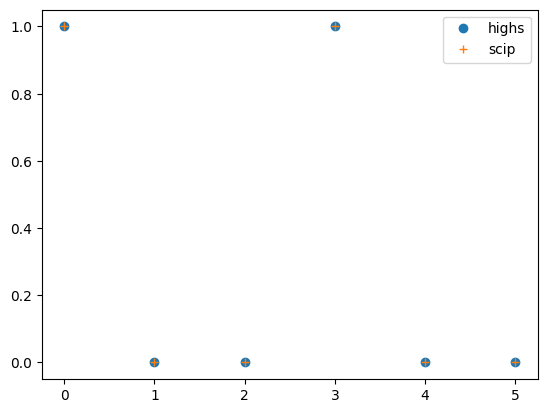

In [3]:
from matplotlib import pyplot as plt

marks = {
    "highs": "o",
    "scip": "+",
}

for name, solution in solutions.items():
    x = solution.extract_decision_variables("x")
    subscripts = [key[0] for key in x.keys()]
    plt.plot(subscripts, x.values(), marks[name], label=name)

plt.legend()

分析する作業によっては `decision_variables` で得られる `pandas.DataFrame` を縦に結合すると便利です。

In [4]:
import pandas

decision_variables = pandas.concat([
    solution.decision_variables.assign(solver=solver)
    for solver, solution in solutions.items()
])
decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value,value,solver
id,,,,,,,,,
0,binary,0.0,1.0,x,[0],<NA>,<NA>,1.0,highs
1,binary,0.0,1.0,x,[1],<NA>,<NA>,0.0,highs
2,binary,0.0,1.0,x,[2],<NA>,<NA>,0.0,highs
3,binary,0.0,1.0,x,[3],<NA>,<NA>,1.0,highs
4,binary,0.0,1.0,x,[4],<NA>,<NA>,0.0,highs
5,binary,0.0,1.0,x,[5],<NA>,<NA>,0.0,highs
0,binary,0.0,1.0,x,[0],<NA>,<NA>,1.0,scip
1,binary,0.0,1.0,x,[1],<NA>,<NA>,0.0,scip
2,binary,0.0,1.0,x,[2],<NA>,<NA>,0.0,scip
